# Your work here!

In [114]:
import matplotlib.pylab as plt #Visualization
import numpy as np # linear algebra
import pandas as pd # data pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler # transforming data(normalize/standardize)
from pathlib import Path
import time # wall time
import os

In [115]:
npTrainMatrix =np.load('data/2018-01-01__2019-01-01__NConservatory_npWeekdayAllOrderedSensorsTimeRef.npy')
npTrainMatrix.shape

(20007, 2112)

In [116]:
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader
import joblib
trainingData=npTrainMatrix
test_data = joblib.load('./test_data/test_dataset_2019.numpy')
test_data.shape

(9898, 2112)

In [117]:
dataLoaderTrain = DataLoader( trainingData.astype('float32'), 
                              batch_size = 18, 
                              shuffle = True )

dataLoaderTest = DataLoader( test_data.astype('float32'), 
                             batch_size = 18, 
                             shuffle = False )

In [118]:
inputDimensionality = trainingData.shape[1]
encoderModel = nn.Sequential(
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.ELU(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.ELU(),
    nn.Linear(inputDimensionality//4, inputDimensionality//10), nn.ELU()
)
decoderModel = nn.Sequential(
    nn.Linear(inputDimensionality//10, inputDimensionality//4), nn.ELU(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.ELU(),
    nn.Linear(inputDimensionality//2, inputDimensionality)
)

# combine
list_of_layers = list(encoderModel.children())
list_of_layers.extend(list(decoderModel.children()))
model = nn.Sequential (*list_of_layers)

# sanity check
list( nn.Sequential(*list(model.children())[0:6]).parameters() ) == list(encoderModel.parameters())

True

In [119]:
targetDeviceCPU = torch.device('cpu')
targetDeviceGPU = torch.device('cuda:0') 
targetDevice = targetDeviceGPU

In [120]:
def train_model ( model, dataLoader, targetDevice, nEpochs = 15 ):

    model = model.to( targetDevice )
    
    lossFunction = nn.MSELoss()
    optimizer = torch.optim.Adam( model.parameters() )
    lossHistory = []
    
    # training loop    
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
            
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( targetDevice )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            loss = lossFunction( predictions, iInputBatch )
            cumulativeLoss += loss.item() # gets scaler value held in the loss tensor
            
            # compute gradients by propagating the error backward through the model/graph
            loss.backward()

            # apply gradients to update model parameters
            optimizer.step()
            
        print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        
        lossHistory += [ cumulativeLoss ]
    return model, lossHistory

In [121]:
startTime = time.time()

model, lossHistory = train_model( model, dataLoaderTrain, targetDevice, nEpochs = 15 )

print('elapsed time : {} '.format(time.time() - startTime))

epoch 0 of 15 -- avg batch loss: 103.67885073646903
epoch 1 of 15 -- avg batch loss: 66.60199907049537
epoch 2 of 15 -- avg batch loss: 57.844421580433846
epoch 3 of 15 -- avg batch loss: 53.94205804169178
epoch 4 of 15 -- avg batch loss: 51.61932164803147
epoch 5 of 15 -- avg batch loss: 49.310033172369
epoch 6 of 15 -- avg batch loss: 46.84092929959297
epoch 7 of 15 -- avg batch loss: 45.777765799313784
epoch 8 of 15 -- avg batch loss: 44.491051863878965
epoch 9 of 15 -- avg batch loss: 42.81079910323024
epoch 10 of 15 -- avg batch loss: 43.19445642828941
epoch 11 of 15 -- avg batch loss: 41.53908166848123
epoch 12 of 15 -- avg batch loss: 41.19431293569505
epoch 13 of 15 -- avg batch loss: 40.18875135295093
epoch 14 of 15 -- avg batch loss: 40.48368473164737
elapsed time : 110.070885181427 


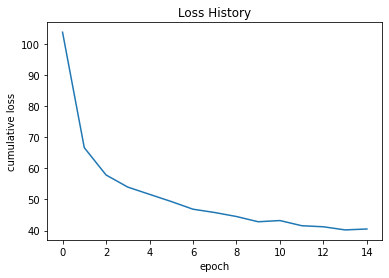

In [122]:
plt.plot(lossHistory)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

In [123]:
def evaluate_model ( model, dataLoader, targetDevice):
    
    predictions, losses = [], []
    ploss=[]
    
    with torch.no_grad():
        
        model=model.eval()
        
        for seq_true in iter(dataLoader):

            
            reconstruction = model.forward(seq_true.to(targetDevice))
            
            sampleNumpy = seq_true.numpy()
            reconstructionNumpy = reconstruction.data.cpu().numpy()

            error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )
            
            losses.append(error)
            ploss.append(np.sum(error))
            predictions.append(reconstructionNumpy.flatten())
            

            
            
    return predictions,losses,ploss
        


In [124]:
predictions,pred_losses,ploss=evaluate_model( model, dataLoaderTest, targetDeviceGPU)

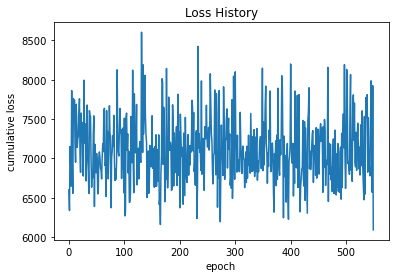

In [125]:
plt.plot(ploss[0:])
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

In [130]:
def evaluate_model ( model, dataLoader, targetDevice, nEvals = 3):

    for iSample in range(nEvals):

        sample = iter(dataLoader).next()[0] # get first element from sample batch        
        reconstruction = model.forward(sample.to(targetDevice))

        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        error = np.sqrt( ((reconstructionNumpy - sampleNumpy)**2))

        plt.figure(figsize=(9,5))
        ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
        ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    
        plt.subplots_adjust(hspace=1)

        ax1.plot(sampleNumpy)
        ax1.plot(reconstructionNumpy, '-.')
        ax1.set_title('sample {}, total error {}'.format(iSample, np.sum(error)))
        ax1.legend(['input data', 'reconstruction'])

        ax2.plot(error)
        ax2.set_title('sample {}, reconstruction error {}'.format(iSample, np.sum(reconstructionNumpy)/10000))
        ax2.legend( ['reconstruction error'] )


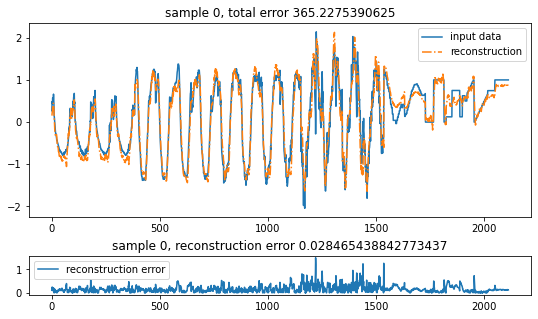

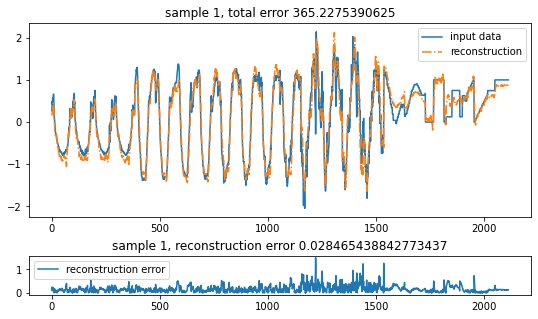

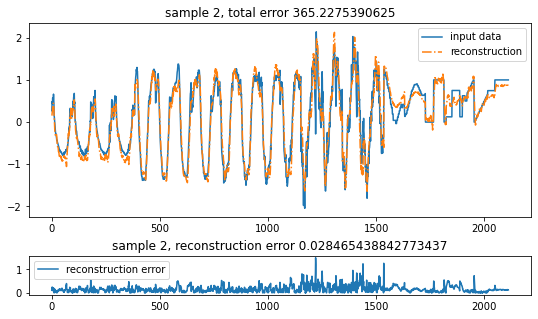

In [131]:
evaluate_model( model, dataLoaderTest, targetDeviceGPU)

In [132]:
#calculating the no of anomalies encountered 
a=[]
for days in pred_losses:
    for day in days:
        c=0
        for item in day[0:1536]:
            if item > 0.5:
                c+=1
        a.append(c)

In [133]:
print('No. of anomalies in the sample is ',c)

No. of anomalies in the sample is  57
